In [1]:
!pip install dfply
import pandas as pd
import numpy as np
import math
from dfply import *
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statistics 
import plotly.graph_objects as go
from scipy import stats
from scipy.stats import pearsonr
import plotly.graph_objects as go
import warnings
from scipy.stats import shapiro
from datetime import date, timedelta

     |████████████████████████████████| 614kB 3.2MB/s 


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
players = pd.read_pickle('/content/drive/My Drive/Capstone/Data/Clean/Players_Clean.pkl')
players = players[players.sofifa_id.notnull()]
players.sofifa_id = players.sofifa_id.astype("int") 

In [0]:
markval = pd.read_pickle("/content/drive/My Drive/Capstone/Data/Clean/markval_detailed.pkl")
stats_wide = pd.read_pickle("/content/drive/My Drive/Capstone/Data/Clean/player_stats_wide.pkl")
cm_sofifa = pd.read_pickle("/content/drive/My Drive/Capstone/Data/Clean/by_position_sofifa/clean_mids_Clean.pkl")
am_sofifa = pd.read_pickle("/content/drive/My Drive/Capstone/Data/Clean/by_position_sofifa/att_mids_Clean.pkl")
dm_sofifa = pd.read_pickle("/content/drive/My Drive/Capstone/Data/Clean/by_position_sofifa/def_mids_Clean.pkl")

In [0]:
def merge_all(df_sofifa, players, markval, stats):
  merged_sofifa = pd.merge(df_sofifa, players[["tm_id","sofifa_id"]])
  merged_sofifa = pd.merge(merged_sofifa, markval, on = ["tm_id","year"])
  no_mv_cols = (merged_sofifa.select_dtypes(include=['float64']) >> select(~X.mv)).columns.tolist()
  no_mv_cols.insert(0, "mv")
  df_sofifa_floats = merged_sofifa[no_mv_cols]
  df_sofifa_stats = pd.merge(merged_sofifa, stats, on = ["tm_id","year"])
  sofifa_cols = df_sofifa.select_dtypes("float64").columns.tolist()
  sofifa_cols.insert(0, "mv")
  return merged_sofifa,df_sofifa_floats,df_sofifa_stats,sofifa_cols
  
def pair_plot(df,h = 900,w = 900):
  col_name = lambda x : x.split("_")[0][0:2] + "_" + x.split("_")[1][0:2] if len(x.split("_")) > 1 else x
  fig = px.scatter_matrix(df,labels=
                        {col: col_name(col) for col in df.columns},
                        height = h, width = w
                        )
  fig.update_traces(diagonal_visible=False)
  # fig.show()
  col_abbrs = {
      "column_abbr" : list(map(col_name, df.columns)),
      "column_name" : df.columns
  }
  return fig, pd.DataFrame(col_abbrs)

def heat_map(df, diagonal = "upper", w = 30,h = 20):
  df = df.select_dtypes(include=['float64'])
  corr = df.corr()
  plt.figure(figsize = (w, h))
  if(diagonal == "lower"):
    mask = np.triu(np.ones_like(corr, dtype=np.bool))
    ax = sns.heatmap(corr, annot = True, linewidths=.5, mask = mask)
  elif(diagonal == "upper"):
    mask = np.tril(np.ones_like(corr, dtype=np.bool))
    ax = sns.heatmap(corr, annot = True, linewidths=.5, mask = mask)
  else:
    ax = sns.heatmap(corr, annot = True, linewidths=.5)
  ax.tick_params(right=True, top=True, labelright=True, labeltop=True)
  plt.show()
  return plt

def get_columns(df,cumulative):
  if(cumulative):
    cols = (df >> select(starts_with('cum'))).columns.tolist()
  else:
    cols = (df >> select(~starts_with('cum'))).columns.tolist()
  return cols

In [0]:
cm_sofifa, cm_sofifa_floats, cm_sofifa_stats, cm_sofifa_cols = merge_all(cm_sofifa, players,markval,stats_wide)
dm_sofifa, dm_sofifa_floats, dm_sofifa_stats, dm_sofifa_cols = merge_all(dm_sofifa, players,markval,stats_wide)
am_sofifa, am_sofifa_floats, am_sofifa_stats, am_sofifa_cols = merge_all(am_sofifa, players,markval,stats_wide)

# Midfielders' attributes in fifa correlation to market value and real life statistics

In [0]:
cm_pp,col_abbrs = pair_plot(cm_sofifa[cm_sofifa_cols])

In [10]:
col_abbrs

,column_abbr,column_name
0,mv,mv
1,passing,passing
2,dribbling,dribbling
3,at_sh,attacking_short_passing
4,sk_ba,skill_ball_control
5,po_st,power_stamina
6,me_vi,mentality_vision
7,cm,cm
8,lcm,lcm
9,rcm,rcm


In [13]:
cm_pp.show()

Output hidden; open in https://colab.research.google.com to view.

Again the fifa attributes are correlated to market value similary, with ball control and short passing attributes having more correlation.

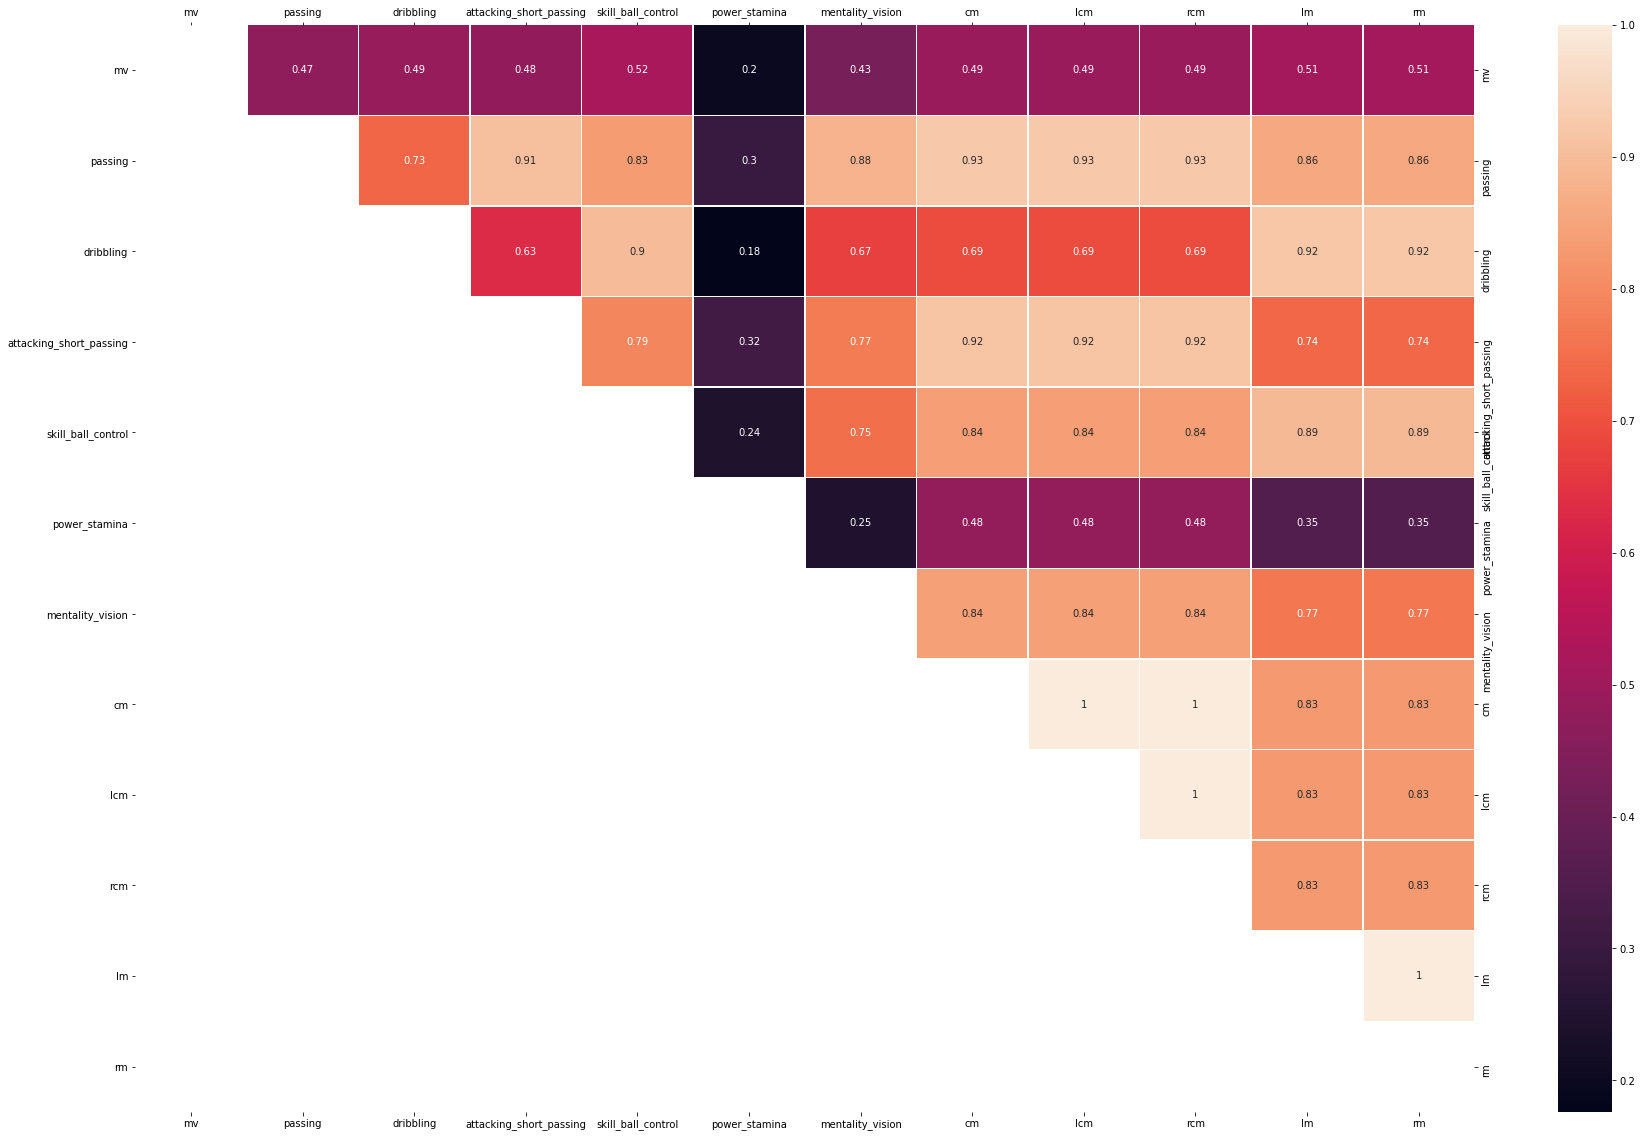

In [16]:
cm_hm = heat_map(cm_sofifa_stats[cm_sofifa_cols], "upper")

Almost all of the attributes are correlated to the player's market value, with stamina having the lowest contribution and ball control having the highest.

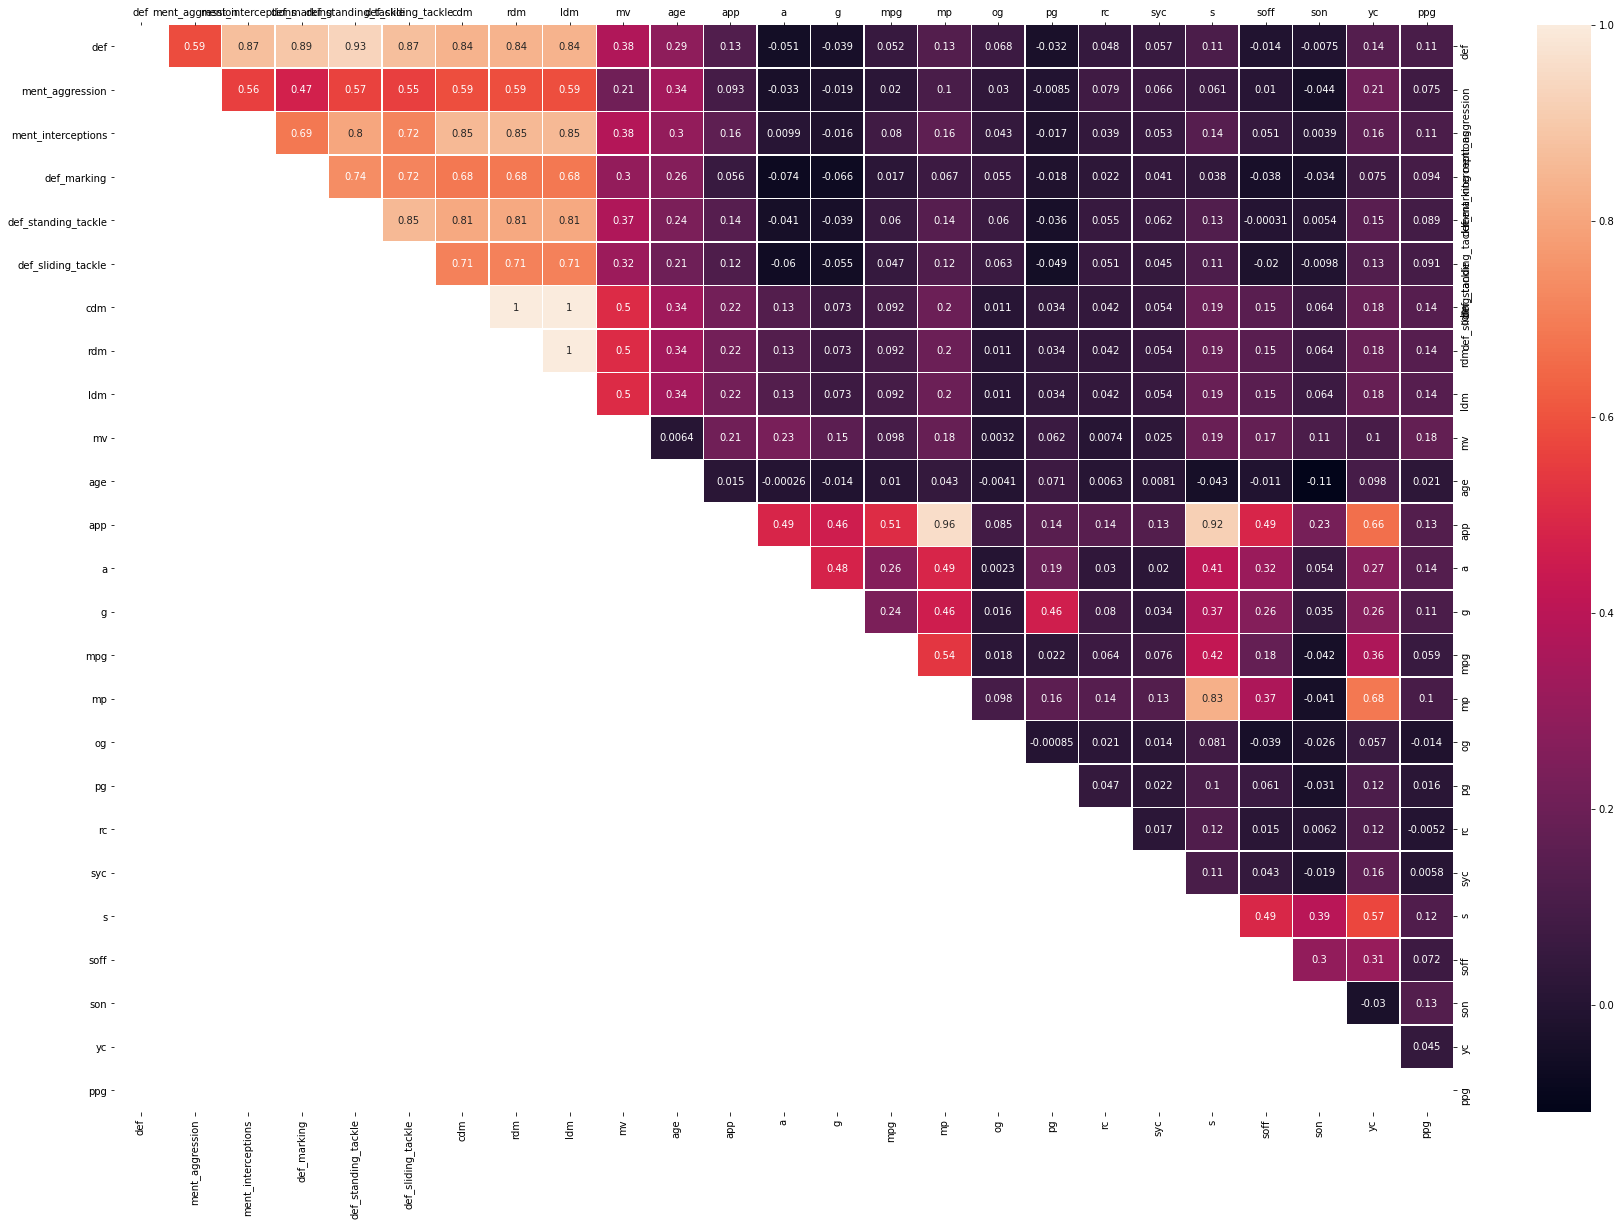

In [23]:
cols = dm_sofifa_stats.columns
cols = [col.replace("defending","def") for col in cols ]
cols = [col.replace("attacking","att") for col in cols ]
cols = [col.replace("mentality","ment") for col in cols ]
dm_sofifa_stats.columns = cols
non_cum = get_columns(dm_sofifa_stats, cumulative = False)
df_hm = heat_map(dm_sofifa_stats[non_cum],"upper")

None of the playing attributes have relatively significant correlation with real stats.

As we can see there are only a few real life statistics metrics that are a little bit correlated to some of the clean midfielders' fifa in game attributes. We can see that the number of assists is correlated to vision, dribbling, passing and ball control attributes, also there is a relatively visible correlation with player's dribbling ability in the game and the number of times he was substituted off the pitch. If the player has good dribling abiliites he is more likely to try play individually with making some dribbles so he is more likely to lose the ball which leads to substituting him off the pitch.

In [0]:
dm_pp,col_abbrs = pair_plot(dm_sofifa[dm_sofifa_cols])

In [18]:
col_abbrs

,column_abbr,column_name
0,mv,mv
1,defending,defending
2,me_ag,mentality_aggression
3,me_in,mentality_interceptions
4,de_ma,defending_marking
5,de_st,defending_standing_tackle
6,de_sl,defending_sliding_tackle
7,cdm,cdm
8,rdm,rdm
9,ldm,ldm


In [19]:
dm_pp.show()

No explicit correlation visible here.

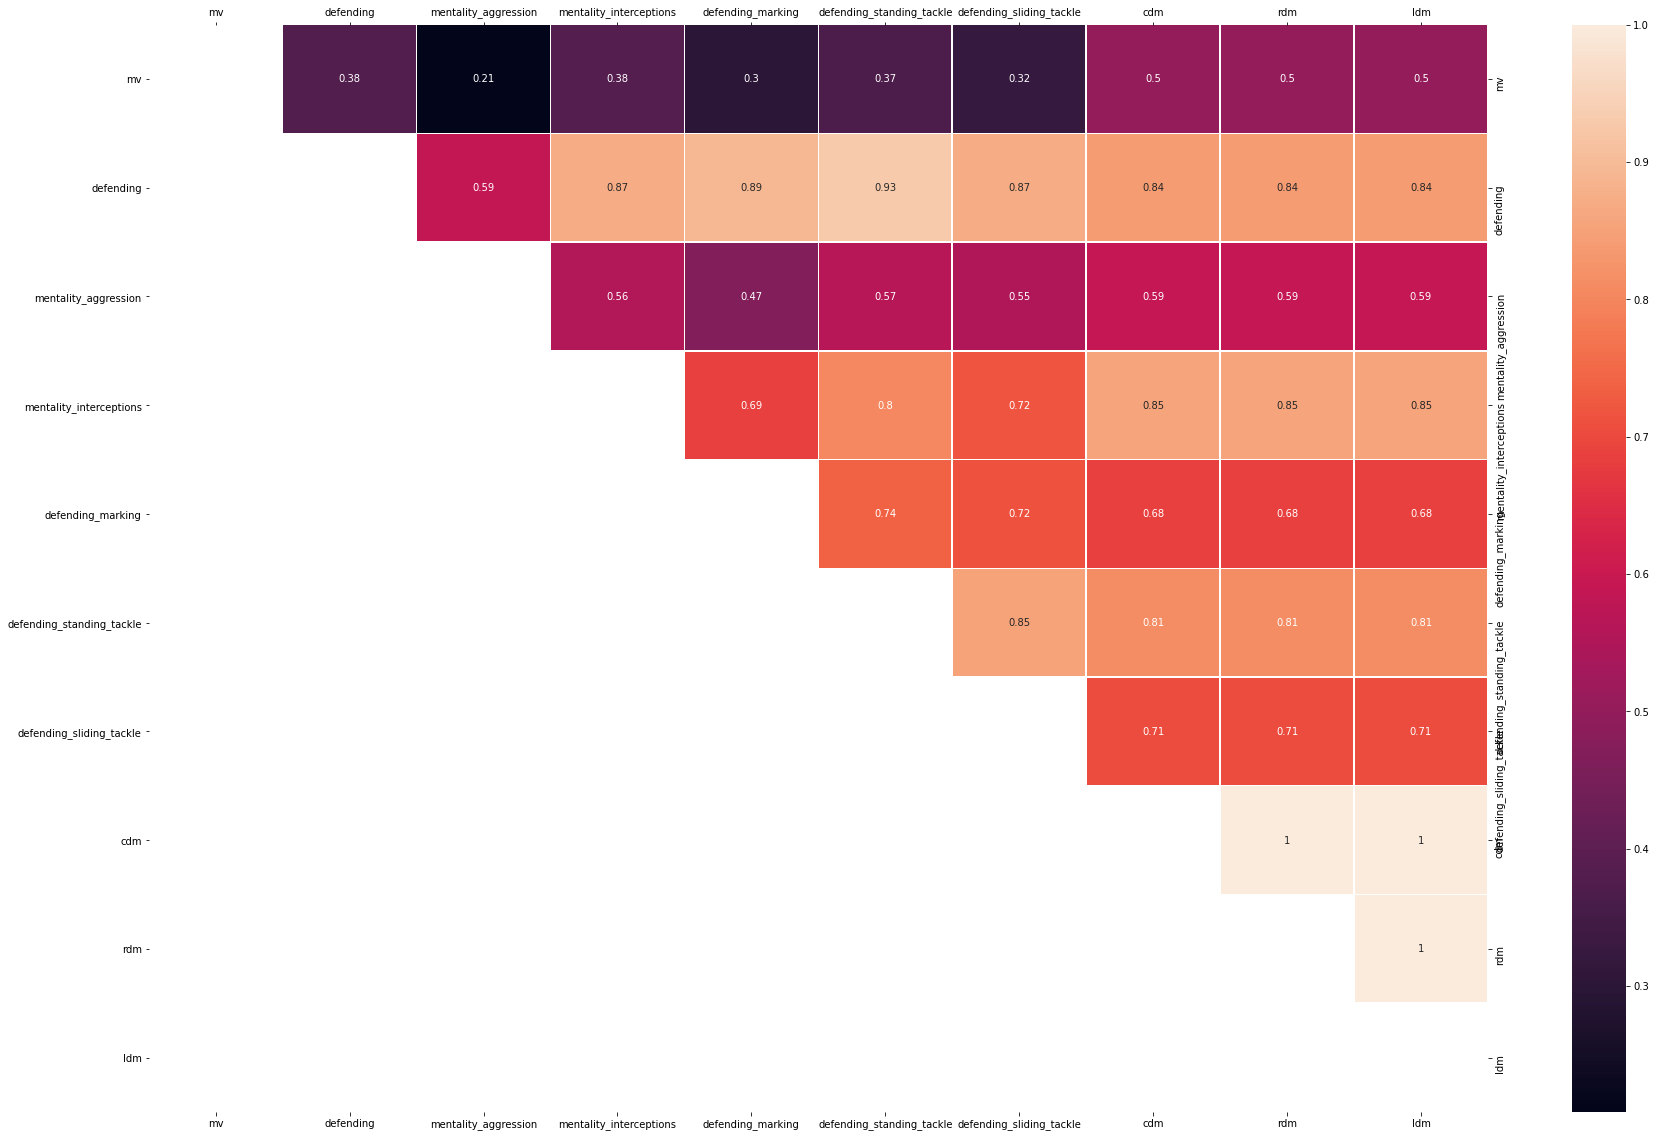

In [20]:
dm_hm = heat_map(dm_sofifa_stats[dm_sofifa_cols], "upper")

The attributes have similar correlation to the market value, the correlation is lower than for central midfielders' attributes, with aggresion having the lowest and defending and intercepiton skills having the highest correlation to the market value.

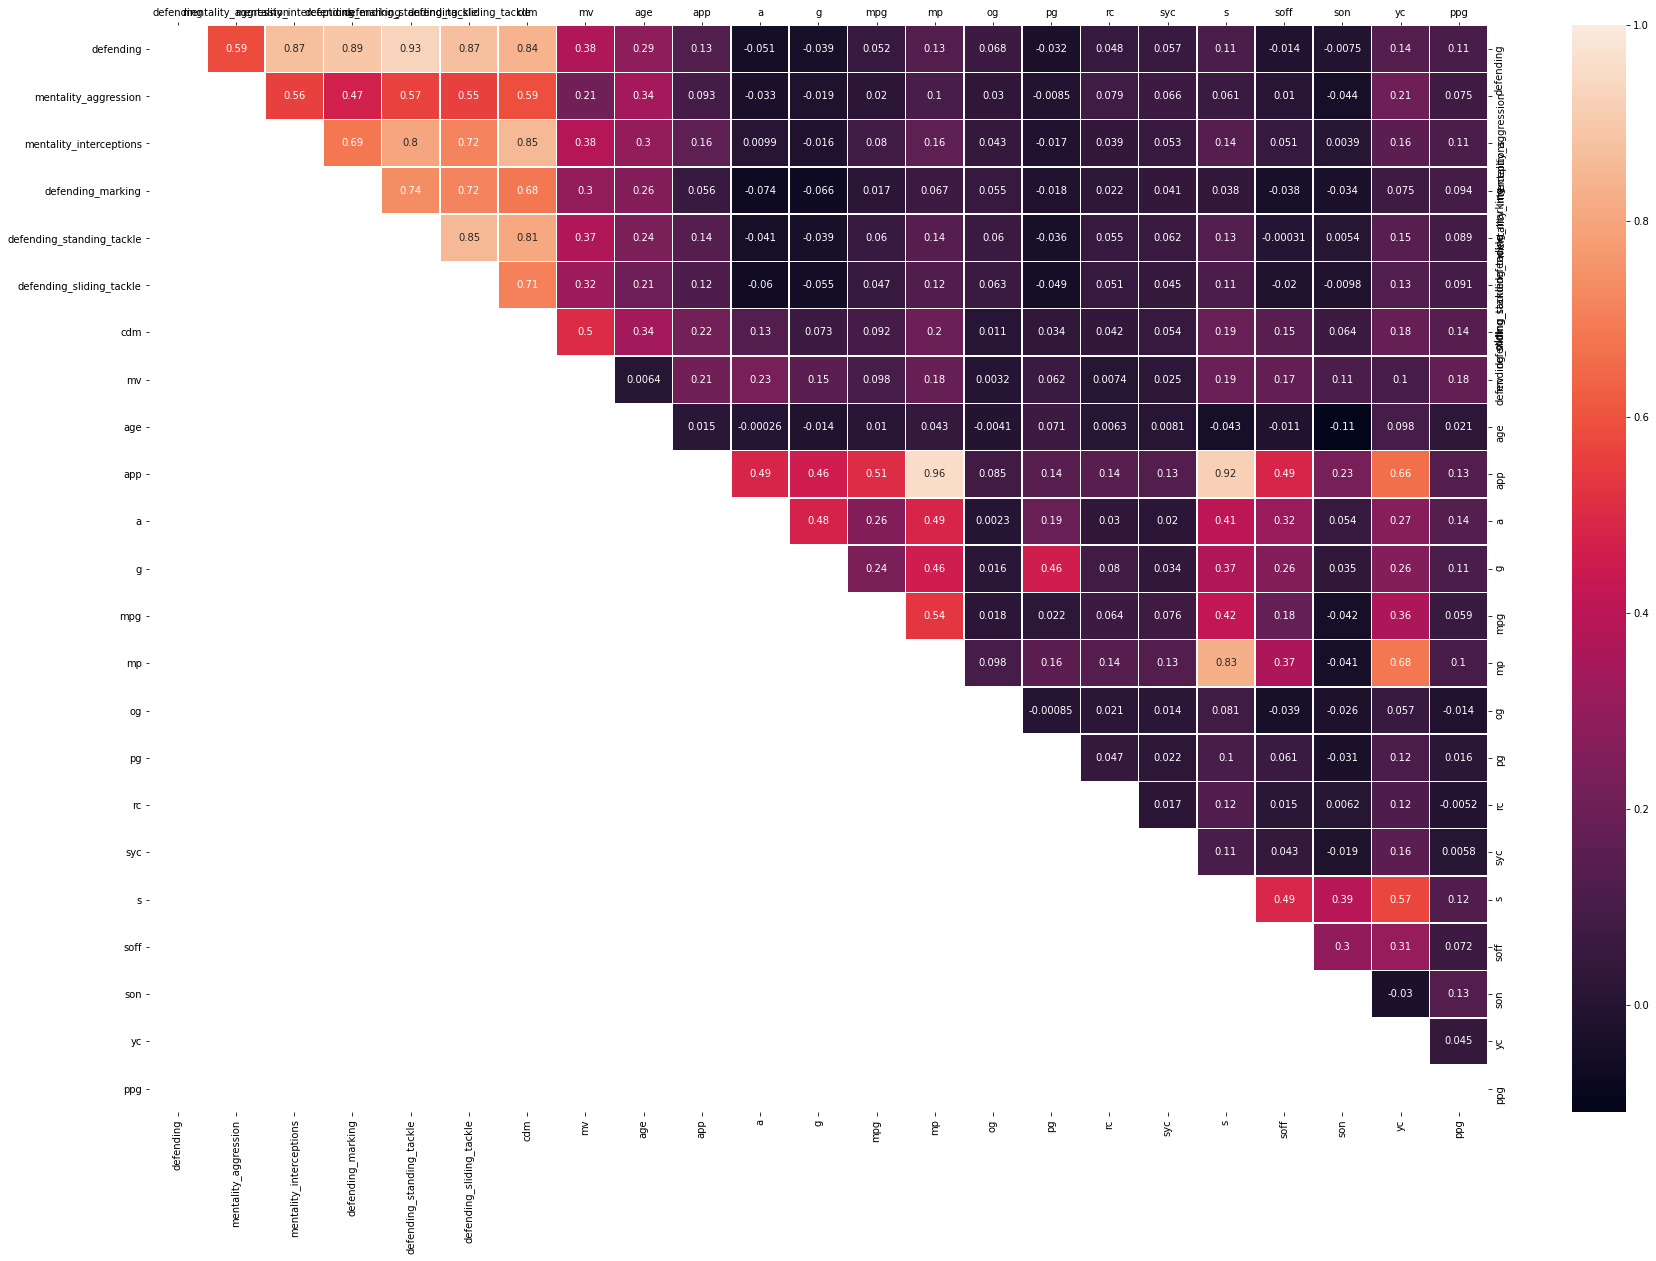

In [22]:
non_cum = get_columns(dm_sofifa_stats, cumulative = False)
dm_hm = heat_map(dm_sofifa_stats[non_cum] >> select(~X.rdm, ~X.ldm),"upper")

In [0]:
am_pp,col_abbrs = pair_plot(am_sofifa[am_sofifa_cols])

In [25]:
col_abbrs

,column_abbr,column_name
0,mv,mv
1,pace,pace
2,passing,passing
3,at_sh,attacking_short_passing
4,sk_ba,skill_ball_control
5,po_st,power_stamina
6,po_lo,power_long_shots
7,me_vi,mentality_vision
8,cam,cam
9,ram,ram


In [27]:
am_pp.show()

It looks like, passing and vision are relatively the most correlated features to market vlaue in playing attrinutes of attacking midfielders.

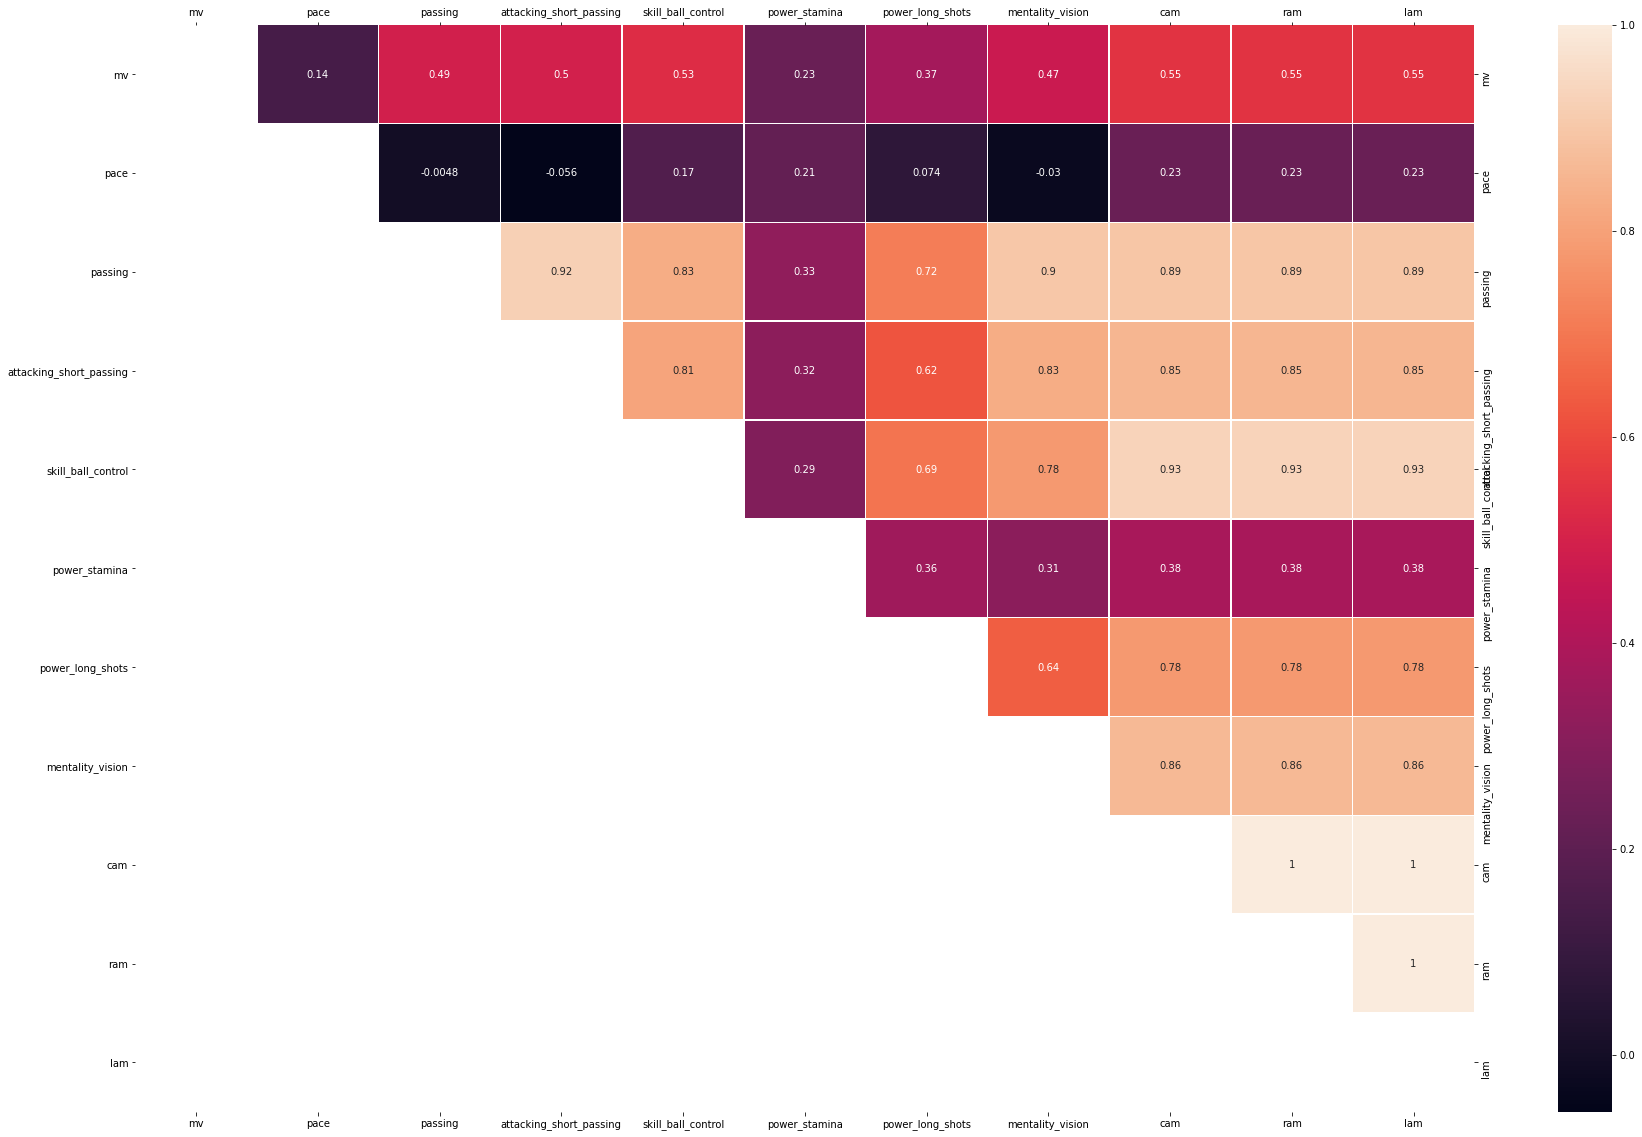

In [28]:
am_hm = heat_map(am_sofifa_stats[am_sofifa_cols], "upper")

Vision passing and ball control attributes have the strongest correlation, while pace and stamina have the lowest. 

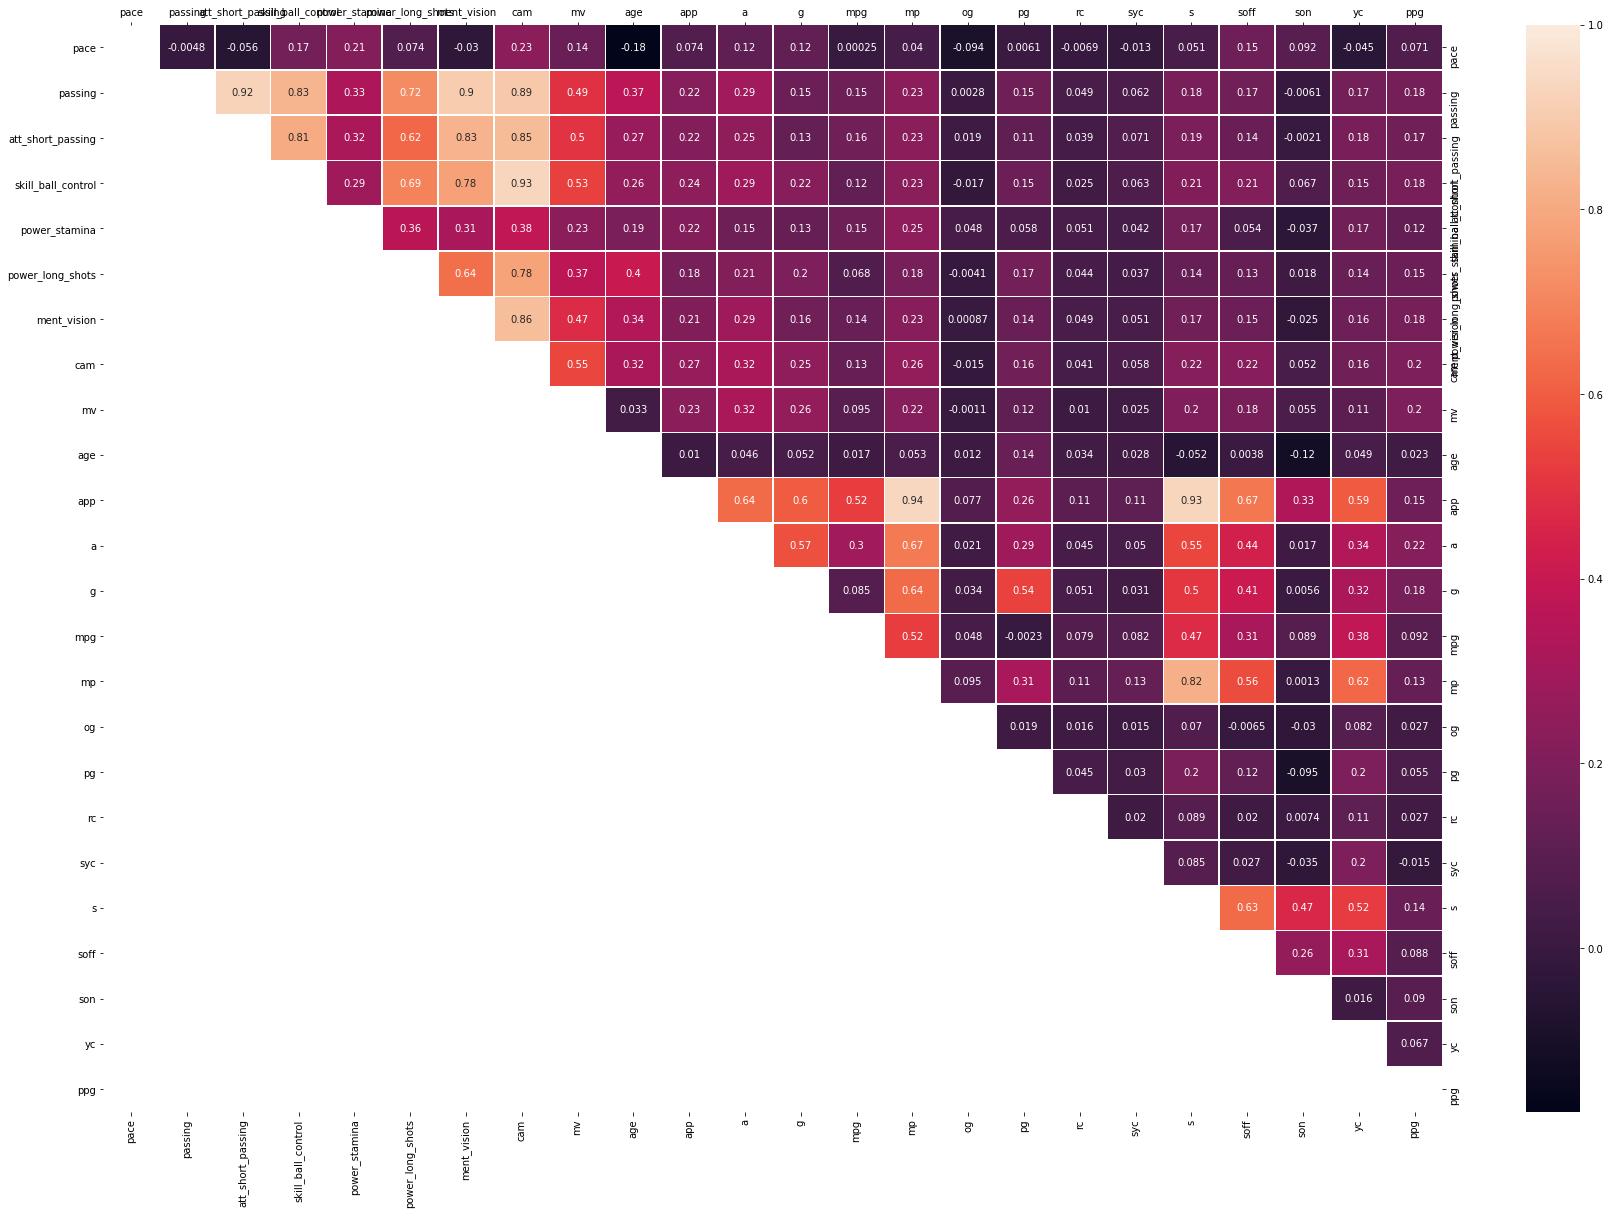

In [30]:
cols = am_sofifa_stats.columns
cols = [col.replace("defending","def") for col in cols ]
cols = [col.replace("attacking","att") for col in cols ]
cols = [col.replace("mentality","ment") for col in cols ]
am_sofifa_stats.columns = cols
non_cum = get_columns(am_sofifa_stats, cumulative = False)
am_hm = heat_map(am_sofifa_stats[non_cum] >> select(~X.ram, ~X.lam),"upper")

The correlation status is the same as for cental midfielders, the number of assists is relateively highly correlated to ball control passing and vision skills. 